<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/Faustino_Testes/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [ ]:
# df_prices = pd.read_csv('sell_prices.csv')

# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# diminuir o tamanho dos datasets
#df_prices = reduce_mem_usage(df_prices)

Mem. usage decreased to 53.64 Mb (78.8% reduction)
Mem. usage decreased to 42.86 Mb (37.5% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [5]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')

dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')


dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

'/content/drive/MyDrive/Save/patient_dot.png'

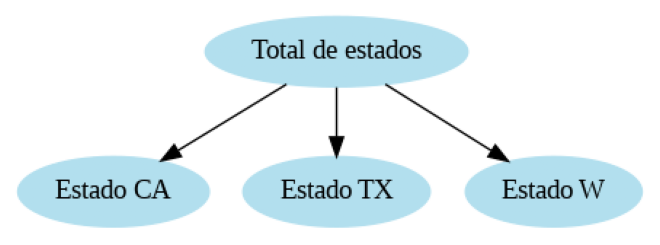

In [6]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Carregar dados (agora concatenados)

# Treino de Modelos

# IGNORAR

A partir daqui, tem apenas código auxiliar para ajudar a obter uma versão reduzida dos dados. Por isso, irá ficar tudo em comentário.





In [ ]:
'''

# (Prices preços) Reduzir os dados para apenas de uma loja

df_prices = pd.read_csv('sell_prices.csv')

csv_path = "df_prices_Loja1.csv"
id_loja = "CA_1"
coluna = "store_id"

# Ler o arquivo CSV existente, se houver
try:
    df_existing = pd.read_csv(csv_path)
except FileNotFoundError:
    df_existing = pd.DataFrame()

index = 0
still_searching = True

while still_searching:
    actual_price = df_prices.iloc[index]
    loja = actual_price[coluna]
    if loja == id_loja:
        print(index, end=' ')
        # Adicionar a linha ao dataframe existente
        df_existing = pd.concat([df_existing, actual_price], ignore_index=True)
        index = index + 1
        continue
    still_searching = False

# Salvar o dataframe resultante no arquivo CSV, adicionando ao final do arquivo
df_existing.to_csv(csv_path, mode='a', index=False, header=not any(df_existing))

'''